In [25]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection
from sklearn.model_selection import ParameterGrid


In [26]:
df = pd.read_csv("../CSVs/daily_revenue.csv", index_col="date", dayfirst=True, parse_dates=True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [27]:
df['revenue'] = df['revenue'].str.replace(',', '').astype(float)
df = df.asfreq('D')
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [28]:
# Transform regressors to float
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype(float) 
df['coupon_rate'] = df['coupon_rate'].str.replace('%', '').astype(float)

df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01
2018-01-04,7785798.0,27.32,0.96
2018-01-05,6375303.0,25.70,0.90


In [29]:
#Splitting the data into training and testing sets
periods = 30
train, test = df.iloc[:-periods], df.iloc[-periods:]
exog_train, exog_test = df.iloc[:-periods, 1:3], df.iloc[-periods:, 1:3]

test.head(), exog_test.head()

(               revenue  discount_rate  coupon_rate
 date                                              
 2022-11-01  16703680.0          23.85         1.50
 2022-11-02  15827022.0          20.76         0.94
 2022-11-03  16154319.0          21.85         0.92
 2022-11-04  14707212.0          20.17         0.88
 2022-11-05  14877530.0          17.85         0.41,
             discount_rate  coupon_rate
 date                                  
 2022-11-01          23.85         1.50
 2022-11-02          20.76         0.94
 2022-11-03          21.85         0.92
 2022-11-04          20.17         0.88
 2022-11-05          17.85         0.41)

In [30]:
# Using pmdarima to find the best SARIMA model and best parameters
model = auto_arima(train['revenue'], m=7, X = exog_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Sat, 21 Jun 2025   AIC                          57250.045
Time:                                   18:30:18   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7882.634      2.082      0.037     961.041    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.146      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.155      0.000    8.04e+05    1.04e+06
ar.L1            -0.6529      0.155     -4.206      0.000      -0.957      -0.349
ar.L2             0.1830      0.048      3.776      0.000       0.088       0.278
ma.L1             0.1070      0.154      0.692      0.489      -0.196       0.410
ma.L2            -0.6926      0.124     -5.579      0.000      -0.936      -0.449
ar.S.L7           0.0523      0.187      0.279      0.780      -0.314       0.419
ar.S.L14          0.9000      0.178      5.065      0.000       0.552       1.248
ma.S.L7           0.0183      0.183      0.100      0.920      -0.339       0.376
ma.S.L14         -0.8501      0.161     -5.290      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016   4.81e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075241.23
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+29. Standard errors may be unstable.
"""

In [31]:
# Prediciton using the best ARIMA model
predictions = model.predict(n_periods=periods, X=exog_test)
predictions

2022-11-01    1.675208e+07
2022-11-02    1.494552e+07
2022-11-03    1.488439e+07
2022-11-04    1.296422e+07
2022-11-05    1.205477e+07
2022-11-06    1.394982e+07
2022-11-07    1.341740e+07
2022-11-08    1.328255e+07
2022-11-09    1.441188e+07
2022-11-10    2.077588e+07
2022-11-11    2.121857e+07
2022-11-12    1.346326e+07
2022-11-13    1.489120e+07
2022-11-14    1.299923e+07
2022-11-15    1.348081e+07
2022-11-16    1.398039e+07
2022-11-17    1.803906e+07
2022-11-18    1.675113e+07
2022-11-19    1.712319e+07
2022-11-20    1.980787e+07
2022-11-21    1.847905e+07
2022-11-22    1.908228e+07
2022-11-23    1.913629e+07
2022-11-24    2.068908e+07
2022-11-25    1.926290e+07
2022-11-26    1.851270e+07
2022-11-27    2.073235e+07
2022-11-28    2.607977e+07
2022-11-29    1.588268e+07
2022-11-30    1.479939e+07
Freq: D, dtype: float64

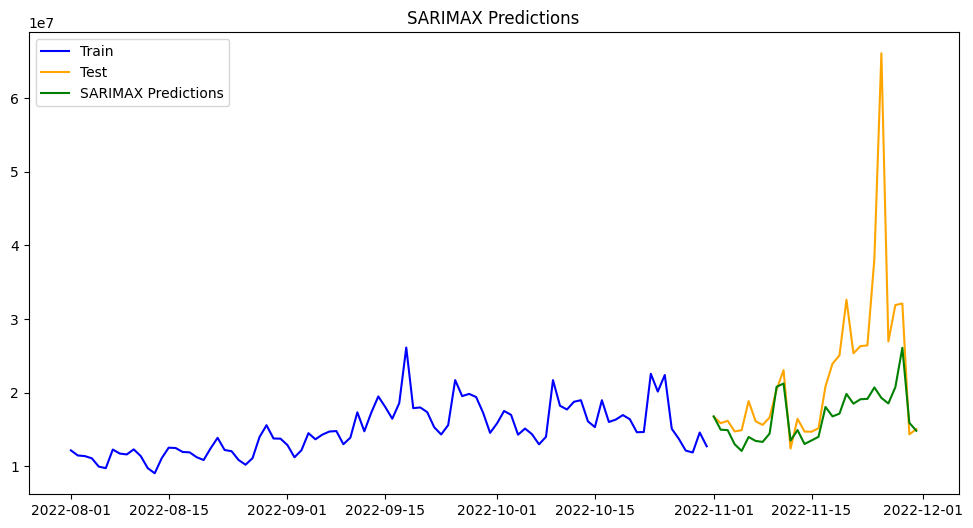

Mean Absolute Error (MAE) for SARIMAX: 5716515.56
Root Mean Squared Error (RMSE) for SARIMAX: 10394588.03
Mean Absolute Percentage Error (MAPE) for SARIMAX: 19.36%


In [32]:
def assess_model(train, test, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train', color='blue')
    plt.plot(test, label='Test', color='orange')
    plt.plot(predictions, label=f'{model_name} Predictions', color='green')
    plt.title(f'{model_name} Predictions')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, predictions)
    print(f'Mean Absolute Error (MAE) for {model_name}: {mae:.2f}')
    rmse = mean_squared_error(test, predictions)  
    rmse = rmse ** 0.5
    print(f'Root Mean Squared Error (RMSE) for {model_name}: {rmse:.2f}')
    mape = mean_absolute_percentage_error(test, predictions)        
    print(f'Mean Absolute Percentage Error (MAPE) for {model_name}: {mape:.2%}') 


assess_model(train['revenue']['2022-08':], test['revenue']['2022-08':], predictions, 'SARIMAX')

# Cross Validation

In [33]:
# Define the model for CV
model_cv = ARIMA(order=model.order, seasonal_order=model.seasonal_order)

In [34]:
# Set the CV rules
cv = model_selection.RollingForecastCV(
    initial=df.shape[0]-180,  # initial training set size
    step= 15, # every 15 days predict next 30 days
    h= 30,

)

In [35]:
# Inputs for CV
cv_scores = model_selection.cross_val_score(
    model_cv, 
    df['revenue'], 
    X = df.iloc[:,1:3], #df[['discount_rate', 'coupon_rate']], 
    cv=cv, 
    scoring='mean_squared_error',
    verbose=1,
    error_score= 100000000000000000000
)

cv_scores

array([1.15261098e+13, 1.38373316e+13, 1.19911341e+13, 1.23864913e+12,
       8.50991131e+11, 7.03693674e+12, 1.22150975e+13, 5.90272546e+12,
       2.97141599e+13, 1.11653581e+13, 1.08047460e+14])

In [36]:
rmse = np.sqrt(np.average(cv_scores))
print(f'Cross-validated RMSE: {rmse:.2f}')

Cross-validated RMSE: 4405842.75


Models Rmse for the last 30 days is 10394588.03 but for a longer period it is 4405842.75 in Cross-Validation

# Parameter Tuning


In [60]:
# Defining the parameters
param_grid = {'p': [1,2,3],
              'd': [0,1],
              'q': [1,2,3],
              'P': [1,2],
              'D': [0],
              'Q': [1,2]}
grid = ParameterGrid(param_grid)
len(list(grid))

72

In [62]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

  # Build an ARIMA model with the current set of parameters
  model = ARIMA(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'], 7))

  # Define the Rolling Forecast Cross-Validation strategy
  cv = model_selection.RollingForecastCV(h=30,
                                         step=15,
                                         initial=df.shape[0] - 180)

  # Perform cross-validation scoring with the ARIMA model
  cv_score = model_selection.cross_val_score(model,
                                             y=df['revenue'],  # Target variable 'y'
                                             X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                             )

  # Calculate RMSE and store the error
  rmse = np.sqrt(np.average(cv_score))
  print(f'Parameters: {params}, RMSE: {rmse:.2f}')
  rmse_list.append(rmse)


Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 1}, RMSE: 4062626.49
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 2}, RMSE: 4045199.38
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 1, 'q': 3}, RMSE: 4045074.78
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 2, 'q': 1}, RMSE: 4059187.37
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 2, 'q': 2}, RMSE: 4057299.15
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 2, 'q': 3}, RMSE: 4099169.39
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 3, 'q': 1}, RMSE: 4067743.19
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 3, 'q': 2}, RMSE: 4057580.31
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'p': 3, 'q': 3}, RMSE: 4113537.56
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 1}, RMSE: 4404026.26
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 2}, RMSE: 4446505.96
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 3}, RMSE: 4432956.98
Parameters: {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 2,

In [63]:
# Create a DataFrame to store the tuning results with parameters and corresponding RMSE values
tuning_results = pd.DataFrame(grid)

# Add the RMSE values calculated during parameter tuning to the DataFrame
tuning_results['rmse'] = rmse_list

tuning_results

,D,P,Q,d,p,q,rmse
0,0,1,1,0,1,1,4.062626e+06
1,0,1,1,0,1,2,4.045199e+06
2,0,1,1,0,1,3,4.045075e+06
3,0,1,1,0,2,1,4.059187e+06
4,0,1,1,0,2,2,4.057299e+06
...,...,...,...,...,...,...,...
67,0,2,2,1,2,2,4.405843e+06
68,0,2,2,1,2,3,4.366104e+06
69,0,2,2,1,3,1,4.413269e+06
70,0,2,2,1,3,2,4.401077e+06


In [64]:
# Save the best parameters
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()].transpose()
best_params


,37
D,0.000000e+00
P,2.000000e+00
Q,1.000000e+00
d,0.000000e+00
p,1.000000e+00
q,2.000000e+00
rmse,4.014441e+06


# Predicting the future

In [65]:
# target variable - daily revenue
y = df['revenue']
# exogenous variables
X = df.iloc[:,1:3]

In [66]:
# Fetch the best parameters
p = int(best_params.loc['p'])
d = int(best_params.loc['d'])
q = int(best_params.loc['q'])
P = int(best_params.loc['P'])
D = int(best_params.loc['D'])
Q = int(best_params.loc['Q'])

In [67]:
# Loading the future regressors data and set the date as index
df_future = pd.read_csv("../CSVs/future_regressors.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df_future.head()

,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [68]:
# multiply all regressor columns by 100
# to make it as percentage values
X_future = df_future.iloc[:,1:3] * 100

In [69]:
# Tuned Sarimax Model with the best parameters
tuned_model = ARIMA(order = (p, d, q),
                    seasonal_order = (P, D, Q, 7))
# fit the model, add exogenous variables as X
tuned_model.fit(y, X = X)

,order,"(1, ...)"
,seasonal_order,"(2, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


In [70]:
# Forecasting
# set the number of periods to forecast to the length of 'X_future'
# add future exogenous variables as X
predictions = tuned_model.predict(n_periods = len(X_future),
                                  X = X_future)

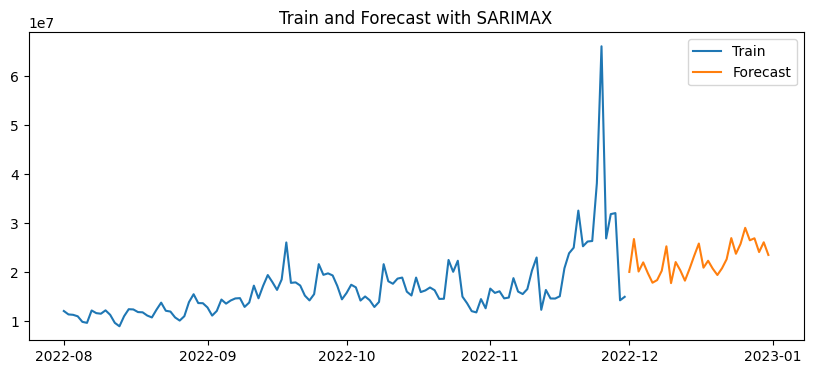

In [72]:
# Data Visualization
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()
  
plot_future(y['2022-08':], predictions, "SARIMAX")